In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import random as random_sparse

In [2]:
# implementing l1 procrustes loss with irls/weighted majorization
# from https://link.springer.com/chapter/10.1007%2F3-540-27373-5_18

# Finding T which minimizes sum i,j abs(e_i,j), where E = Y - XT
# if no initial T input, it is random normal
def l1proc_min(X, Y, num_iters, T_init=None):
    n, k = X.shape
    if T_init is None:
        T_0 = np.random.normal(size=(k,k))
    else:
        T_0 = T_init
    err = np.zeros((num_iters))
    
    for curr_it in range(num_iters):
        if curr_it == 0:
            noise = np.zeros(Y.shape)
        else:
            noise = np.random.normal(loc=0, scale=1/((curr_it+1)**2), size=(Y.shape)) # smaller variance each iter
            
        E_0 = (Y - X.dot(T_0)) + noise # adding random noise to error matrix - seems to help with local minima
        if np.any(E_0 == 0):
            return T_0, err
        W = 1 / np.abs(E_0) 
    
        err[curr_it] = np.abs(E_0).sum()
        
        D_m = np.diag(W.max(axis=1))   
        weight = np.divide(W, W.max(axis=1).reshape((n,1)))
        R = np.multiply((1 - weight), X.dot(T_0)) + np.multiply(weight, Y)
        
        S = np.dot(np.dot(np.transpose(X), D_m), R)
        U, sig, V_T = np.linalg.svd(S)
        T = U.dot(V_T)
        E = Y - X.dot(T)
        T_0 = T
    return T_0, err

# Orthogonal procrustes l2 soln
def l2proc_min(X, Y):
    M = X.T.dot(Y)
    U, S, V_T = np.linalg.svd(M)
    T = U.dot(V_T)
    return T
    

In [3]:
%%time

# modeling sparse errors for XT - Y = E
# X = (E + Y)T^-1
n, k = 100, 100
sparse_mat = random_sparse(n, k, density=1/1000)
E = sparse_mat.A
T_true, _ = np.linalg.qr(np.random.normal(size=(k,k)))  # T is orthogonal
Y = np.random.normal(size=(n,k))
X = np.dot(E + Y, T_true.T)
print('True err:\t' + str(np.abs(E).sum()))

# L2 soln
T_l2 = l2proc_min(X, Y)
E_l2 = Y - X.dot(T_l2)
print('l2 err:\t\t', np.sum(np.abs(E_l2)))

# init with l2 soln
errs = np.array([])
T_l1_lowest, err = l1proc_min(X, Y, num_iters=100, T_init=T_l2)
lowest_err = err[np.nonzero(err)[-1][-1]]  # gets last error

# chain together 100 starts
for i in range(100):
    T_l1, err = l1proc_min(X, Y, num_iters=150, T_init=T_l1_lowest)
    E_l1 = Y - X.dot(T_l1)
    nonzero_min = err[np.nonzero(err)[-1][-1]]
    np.append(errs, np.sum(np.abs(E_l1)))
    if nonzero_min < lowest_err:
        print('curr err:\t' + str(nonzero_min))
        if lowest_err - nonzero_min < .1:
            print('small decrease in error. stopping.')
            break
        else:
            T_l1_lowest = T_l1
            lowest_err = nonzero_min
            E_l1_lowest = E_l1
            errs = np.append(errs, err)
    else:
        print('increase err:\t' + str(nonzero_min))  # keep going to possibly get out of local minima
#         if lowest_err - nonzero_min < 1:
#             break
#         print('increase in error. stopping.')
#         break

True err:	5.387115329318745
l2 err:		 72.6406385279274
curr err:	38.01838321611737
curr err:	28.441203252284517
curr err:	20.839446312198877
curr err:	15.55035791020995
curr err:	11.375697428071897
curr err:	8.576266264733267
curr err:	6.882429862574099
curr err:	5.981674596196989
curr err:	5.76028309186423
curr err:	5.742872927272401
small decrease in error. stopping.
CPU times: user 23.1 s, sys: 45.8 s, total: 1min 8s
Wall time: 8.77 s


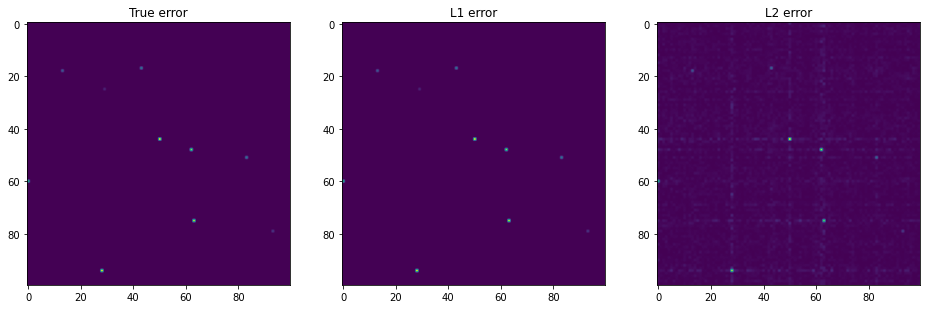

5.43995413265488 72.6406385279274


In [4]:
fig, ax = plt.subplots(1, 3, figsize=(16, 16))
im = ax[0].imshow(np.abs(E)) 
# plt.colorbar(im, ax=ax[0])
im = ax[1].imshow(np.abs(E_l1_lowest))
# fig.colorbar(im, ax=ax[1])
im = ax[2].imshow(np.abs(E_l2))
# fig.colorbar(im, ax=ax[2])
ax[0].set(title='True error')
ax[1].set(title='L1 error')
ax[2].set(title='L2 error')

plt.show()

print(np.abs(E_l1).sum(), np.abs(E_l2).sum())

# fig, ax = plt.subplots(1, 3, sharey=True)
# im = ax[0].imshow(T_true)
# fig.colorbar(im, ax=ax[0])
# im = ax[1].imshow(T_l1_lowest - T_true)
# fig.colorbar(im, ax=ax[1])
# im = ax[2].imshow(T_l2 - T_true)
# fig.colorbar(im, ax=ax[2])
# ax[0].set(title='T_true')
# ax[1].set(title='T_l1')
# ax[2].set(title='T_l2')

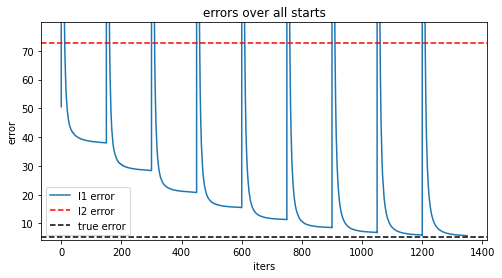

In [5]:
l2_sum_err = np.abs(E_l2).sum()
true_err = np.abs(E).sum()

fig, ax = plt.subplots(figsize=(8,4))
ax.plot(errs, label='l1 error')
ax.axhline(l2_sum_err, color='r', linestyle='--', label='l2 error')
ax.axhline(true_err, color='k', linestyle='--', label='true error')
ax.set(xlabel='iters', ylabel='error', title='errors over all starts',
      ylim=(true_err-(true_err/5), l2_sum_err+(l2_sum_err/10)))
plt.legend()
plt.show()

In [ ]:
def moving_average(a, n) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n